# Phase 4b: Hyperparameter Tuning with Optuna

This notebook uses Optuna to find optimal hyperparameters for our advanced models.

**Objectives:**
- Use Optuna for automated hyperparameter optimization
- Tune LightGBM, XGBoost, and CatBoost independently
- Use time-series CV for robust evaluation
- Compare tuned results to manually specified hyperparameters
- Track all experiments in MLflow
- Save best hyperparameters for final model training

**Strategy:**
- Each model gets its own Optuna study
- Use pruning to stop unpromising trials early
- Target metric: RMSPE (minimize)
- Budget: 50-100 trials per model (adjustable)

**CRITICAL:** All experiments tracked with MLflow for reproducibility.

## Setup

In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import json
import optuna
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import mlflow
from optuna.integration.mlflow import MLflowCallback

from evaluation.cv import (
    make_time_series_folds,
    filter_open_stores,
    remove_missing_features
)
from evaluation.metrics import rmspe
from utils.io import read_parquet
from utils.mlflow_utils import setup_mlflow, log_dvc_data_version

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Setup MLflow
experiment_id = setup_mlflow()
print(f"MLflow experiment ID: {experiment_id}")
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print("\nSetup complete!")

MLflow experiment ID: 211292085284843771
MLflow tracking URI: /Users/b294776/Desktop/Projects/rossmann-forecasting/mlruns

Setup complete!


/Users/b294776/Desktop/Projects/rossmann-forecasting/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)


## 1. Load Data and Create CV Folds

In [2]:
# Load featured data
df = read_parquet('../data/processed/train_features.parquet')

print(f"Loaded data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Loaded data shape: (1017209, 50)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00


In [3]:
# Load CV config
with open('../config/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

cv_config = params['cv']

print("Cross-Validation Configuration:")
print(f"  N folds: {cv_config['n_folds']}")
print(f"  Fold length: {cv_config['fold_length_days']} days")

Cross-Validation Configuration:
  N folds: 5
  Fold length: 42 days


In [4]:
# Filter and create folds
df_open = filter_open_stores(df)

# Create folds
folds = make_time_series_folds(
    df_open,
    n_folds=cv_config['n_folds'],
    fold_length_days=cv_config['fold_length_days'],
    min_train_days=cv_config['min_train_days']
)

# Define feature columns
exclude_cols = ['Sales', 'Date', 'Store', 'Customers']
feature_cols = [col for col in df_open.columns if col not in exclude_cols]

print(f"\nCreated {len(folds)} folds")
print(f"Features: {len(feature_cols)}")

2025-12-15 11:24:32 - evaluation.cv - INFO - Filtered out 172,817 closed store-days (16.99%)
2025-12-15 11:24:32 - evaluation.cv - INFO - Remaining: 844,392 open store-days
2025-12-15 11:24:32 - evaluation.cv - INFO - ============================================================
2025-12-15 11:24:32 - evaluation.cv - INFO - Creating time-series cross-validation folds
2025-12-15 11:24:32 - evaluation.cv - INFO - ============================================================
2025-12-15 11:24:32 - evaluation.cv - INFO - Number of folds: 5
2025-12-15 11:24:32 - evaluation.cv - INFO - Validation fold length: 42 days (6 weeks)
2025-12-15 11:24:32 - evaluation.cv - INFO - Minimum training days: 365 days (1 year)
2025-12-15 11:24:32 - evaluation.cv - INFO - Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
2025-12-15 11:24:32 - evaluation.cv - INFO - Total unique dates: 942
2025-12-15 11:24:32 - evaluation.cv - INFO - 
First validation period starts at: 2014-01-01 00:00:00
2025-12-15 11:24:32

## 2. Define Hyperparameter Search Spaces

For each model, we define the hyperparameters to tune and their search ranges.

In [5]:
# Number of trials per model
N_TRIALS = 50  # Increase to 100+ for better results (but takes longer)

print(f"Hyperparameter tuning configuration:")
print(f"  Trials per model: {N_TRIALS}")
print(f"  CV folds: {len(folds)}")
print(f"  Estimated time per model: {N_TRIALS * len(folds) * 10 / 60:.0f} minutes (rough estimate)")

Hyperparameter tuning configuration:
  Trials per model: 50
  CV folds: 5
  Estimated time per model: 42 minutes (rough estimate)


## 3. Tune LightGBM

Use Optuna to find optimal LightGBM hyperparameters.

**Tracked in MLflow:** Each trial logged as nested run with parameters and RMSPE metric.

In [6]:
def objective_lightgbm(trial):
    """
    Optuna objective function for LightGBM hyperparameter tuning.
    """
    # Define hyperparameter search space
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'verbose': -1,
        'seed': 42
    }
    
    # Evaluate using CV
    fold_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(folds):
        # Get train and validation data
        train_data = df_open.iloc[train_idx].copy()
        val_data = df_open.iloc[val_idx].copy()
        
        # Remove rows with missing features
        train_data, valid_features = remove_missing_features(train_data, feature_cols)
        val_data, _ = remove_missing_features(val_data, valid_features)
        
        # Prepare data
        X_train = train_data[valid_features]
        y_train = train_data['Sales']
        X_val = val_data[valid_features]
        y_val = val_data['Sales']
        
        # Create LightGBM datasets
        train_set = lgb.Dataset(X_train, label=y_train)
        val_set = lgb.Dataset(X_val, label=y_val, reference=train_set)
        
        # Train model
        model = lgb.train(
            params,
            train_set,
            num_boost_round=2000,
            valid_sets=[val_set],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        
        # Predict and evaluate
        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        score = rmspe(y_val.values, y_pred)
        fold_scores.append(score)
        
        # Report intermediate value for pruning
        trial.report(np.mean(fold_scores), fold_idx)
        
        # Prune unpromising trials
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return np.mean(fold_scores)

In [7]:
# Start parent MLflow run for LightGBM tuning
with mlflow.start_run(run_name="lightgbm_optuna_tuning") as parent_run:
    print("="*60)
    print("Tuning LightGBM Hyperparameters")
    print("="*60)
    
    # Log DVC data version
    log_dvc_data_version("data/processed/train_features.parquet")
    
    # Log tuning metadata
    mlflow.log_param("model_type", "lightgbm")
    mlflow.log_param("tuning_method", "optuna")
    mlflow.log_param("n_trials", N_TRIALS)
    mlflow.log_param("n_folds", len(folds))
    mlflow.log_param("pruner", "MedianPruner")
    
    # Create MLflow callback for Optuna
    mlflc = MLflowCallback(
        tracking_uri=mlflow.get_tracking_uri(),
        metric_name="rmspe",
        create_experiment=False,
        mlflow_kwargs={"nested": True}
    )
    
    # Create and run study
    study_lgb = optuna.create_study(
        direction='minimize',
        study_name='lightgbm_tuning',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
    )
    
    study_lgb.optimize(
        objective_lightgbm,
        n_trials=N_TRIALS,
        callbacks=[mlflc],
        show_progress_bar=True
    )
    
    # Log best results
    mlflow.log_metric("best_rmspe", study_lgb.best_value)
    mlflow.log_metric("n_trials_completed", len(study_lgb.trials))
    
    # Log best hyperparameters
    for key, value in study_lgb.best_params.items():
        mlflow.log_param(f"best_{key}", value)
    
    print(f"\nBest RMSPE: {study_lgb.best_value:.6f}")
    print(f"\nBest hyperparameters:")
    for key, value in study_lgb.best_params.items():
        print(f"  {key}: {value}")
    
    print(f"\nMLflow Run ID: {parent_run.info.run_id}")

Tuning LightGBM Hyperparameters


/var/folders/8f/c06lv6q17tjbyjv2nkt0_s4s1sh0tg/T/ipykernel_40931/3351439756.py:18: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(


  0%|          | 0/50 [00:00<?, ?it/s]

2025-12-15 11:24:33 - evaluation.cv - INFO - Removed 25,547 rows with missing features (7.56%)
2025-12-15 11:24:33 - evaluation.cv - INFO - Remaining: 312,396 complete rows
2025-12-15 11:24:33 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 11:24:33 - evaluation.cv - INFO - Remaining: 38,761 complete rows
2025-12-15 11:24:37 - evaluation.cv - INFO - Removed 25,547 rows with missing features (6.78%)
2025-12-15 11:24:37 - evaluation.cv - INFO - Remaining: 351,157 complete rows
2025-12-15 11:24:37 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 11:24:37 - evaluation.cv - INFO - Remaining: 40,164 complete rows
2025-12-15 11:24:47 - evaluation.cv - INFO - Removed 25,547 rows with missing features (6.13%)
2025-12-15 11:24:47 - evaluation.cv - INFO - Remaining: 391,321 complete rows
2025-12-15 11:24:47 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 11:24:47 - evaluation.cv - INFO - Remaining: 3

## 4. Tune XGBoost

Use Optuna to find optimal XGBoost hyperparameters.

**Tracked in MLflow:** Each trial logged as nested run with parameters and RMSPE metric.

In [8]:
def objective_xgboost(trial):
    """
    Optuna objective function for XGBoost hyperparameter tuning.
    """
    # Define hyperparameter search space
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'seed': 42,
        'verbosity': 0
    }
    
    # Evaluate using CV
    fold_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(folds):
        # Get train and validation data
        train_data = df_open.iloc[train_idx].copy()
        val_data = df_open.iloc[val_idx].copy()
        
        # Remove rows with missing features
        train_data, valid_features = remove_missing_features(train_data, feature_cols)
        val_data, _ = remove_missing_features(val_data, valid_features)
        
        # Prepare data
        X_train = train_data[valid_features].copy()
        y_train = train_data['Sales']
        X_val = val_data[valid_features].copy()
        y_val = val_data['Sales']
        
        # Convert categoricals to codes for XGBoost
        for col in X_train.columns:
            if X_train[col].dtype.name == 'category':
                X_train[col] = X_train[col].cat.codes
                X_val[col] = X_val[col].cat.codes
        
        # Create XGBoost datasets
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        # Train model
        evals = [(dval, 'valid')]
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=2000,
            evals=evals,
            early_stopping_rounds=100,
            verbose_eval=False
        )
        
        # Predict and evaluate
        y_pred = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
        score = rmspe(y_val.values, y_pred)
        fold_scores.append(score)
        
        # Report intermediate value for pruning
        trial.report(np.mean(fold_scores), fold_idx)
        
        # Prune unpromising trials
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return np.mean(fold_scores)

In [9]:
# Start parent MLflow run for XGBoost tuning
with mlflow.start_run(run_name="xgboost_optuna_tuning") as parent_run:
    print("="*60)
    print("Tuning XGBoost Hyperparameters")
    print("="*60)
    
    # Log DVC data version
    log_dvc_data_version("data/processed/train_features.parquet")
    
    # Log tuning metadata
    mlflow.log_param("model_type", "xgboost")
    mlflow.log_param("tuning_method", "optuna")
    mlflow.log_param("n_trials", N_TRIALS)
    mlflow.log_param("n_folds", len(folds))
    mlflow.log_param("pruner", "MedianPruner")
    
    # Create MLflow callback for Optuna
    mlflc = MLflowCallback(
        tracking_uri=mlflow.get_tracking_uri(),
        metric_name="rmspe",
        create_experiment=False,
        mlflow_kwargs={"nested": True}
    )
    
    # Create and run study
    study_xgb = optuna.create_study(
        direction='minimize',
        study_name='xgboost_tuning',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
    )
    
    study_xgb.optimize(
        objective_xgboost,
        n_trials=N_TRIALS,
        callbacks=[mlflc],
        show_progress_bar=True
    )
    
    # Log best results
    mlflow.log_metric("best_rmspe", study_xgb.best_value)
    mlflow.log_metric("n_trials_completed", len(study_xgb.trials))
    
    # Log best hyperparameters
    for key, value in study_xgb.best_params.items():
        mlflow.log_param(f"best_{key}", value)
    
    print(f"\nBest RMSPE: {study_xgb.best_value:.6f}")
    print(f"\nBest hyperparameters:")
    for key, value in study_xgb.best_params.items():
        print(f"  {key}: {value}")
    
    print(f"\nMLflow Run ID: {parent_run.info.run_id}")

Tuning XGBoost Hyperparameters


/var/folders/8f/c06lv6q17tjbyjv2nkt0_s4s1sh0tg/T/ipykernel_40931/2688644682.py:18: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(


  0%|          | 0/50 [00:00<?, ?it/s]

2025-12-15 13:05:33 - evaluation.cv - INFO - Removed 25,547 rows with missing features (7.56%)
2025-12-15 13:05:33 - evaluation.cv - INFO - Remaining: 312,396 complete rows
2025-12-15 13:05:33 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 13:05:33 - evaluation.cv - INFO - Remaining: 38,761 complete rows
2025-12-15 13:05:35 - evaluation.cv - INFO - Removed 25,547 rows with missing features (6.78%)
2025-12-15 13:05:35 - evaluation.cv - INFO - Remaining: 351,157 complete rows
2025-12-15 13:05:35 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 13:05:35 - evaluation.cv - INFO - Remaining: 40,164 complete rows
2025-12-15 13:05:47 - evaluation.cv - INFO - Removed 25,547 rows with missing features (6.13%)
2025-12-15 13:05:47 - evaluation.cv - INFO - Remaining: 391,321 complete rows
2025-12-15 13:05:47 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 13:05:47 - evaluation.cv - INFO - Remaining: 3

## 5. Tune CatBoost

Use Optuna to find optimal CatBoost hyperparameters.

**Tracked in MLflow:** Each trial logged as nested run with parameters and RMSPE metric.

In [10]:
def objective_catboost(trial):
    """
    Optuna objective function for CatBoost hyperparameter tuning.
    """
    # Define hyperparameter search space
    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'depth': trial.suggest_int('depth', 5, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False,
        'random_seed': 42
    }
    
    # Identify categorical features
    cat_features = [
        col for col in feature_cols
        if df_open[col].dtype in ['object', 'category']
    ]
    
    # Evaluate using CV
    fold_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(folds):
        # Get train and validation data
        train_data = df_open.iloc[train_idx].copy()
        val_data = df_open.iloc[val_idx].copy()
        
        # Remove rows with missing features
        train_data, valid_features = remove_missing_features(train_data, feature_cols)
        val_data, _ = remove_missing_features(val_data, valid_features)
        
        # Update categorical features
        valid_cat_features = [col for col in cat_features if col in valid_features]
        
        # Prepare data
        X_train = train_data[valid_features]
        y_train = train_data['Sales']
        X_val = val_data[valid_features]
        y_val = val_data['Sales']
        
        # Create CatBoost datasets
        train_pool = cb.Pool(X_train, label=y_train, cat_features=valid_cat_features)
        val_pool = cb.Pool(X_val, label=y_val, cat_features=valid_cat_features)
        
        # Train model
        model = cb.CatBoost(params)
        model.fit(
            train_pool,
            eval_set=val_pool,
            early_stopping_rounds=100,
            verbose=False
        )
        
        # Predict and evaluate
        y_pred = model.predict(val_pool)
        score = rmspe(y_val.values, y_pred)
        fold_scores.append(score)
        
        # Report intermediate value for pruning
        trial.report(np.mean(fold_scores), fold_idx)
        
        # Prune unpromising trials
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return np.mean(fold_scores)

In [11]:
# Start parent MLflow run for CatBoost tuning
with mlflow.start_run(run_name="catboost_optuna_tuning") as parent_run:
    print("="*60)
    print("Tuning CatBoost Hyperparameters")
    print("="*60)
    
    # Log DVC data version
    log_dvc_data_version("data/processed/train_features.parquet")
    
    # Log tuning metadata
    mlflow.log_param("model_type", "catboost")
    mlflow.log_param("tuning_method", "optuna")
    mlflow.log_param("n_trials", N_TRIALS)
    mlflow.log_param("n_folds", len(folds))
    mlflow.log_param("pruner", "MedianPruner")
    
    # Create MLflow callback for Optuna
    mlflc = MLflowCallback(
        tracking_uri=mlflow.get_tracking_uri(),
        metric_name="rmspe",
        create_experiment=False,
        mlflow_kwargs={"nested": True}
    )
    
    # Create and run study
    study_cb = optuna.create_study(
        direction='minimize',
        study_name='catboost_tuning',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
    )
    
    study_cb.optimize(
        objective_catboost,
        n_trials=N_TRIALS,
        callbacks=[mlflc],
        show_progress_bar=True
    )
    
    # Log best results
    mlflow.log_metric("best_rmspe", study_cb.best_value)
    mlflow.log_metric("n_trials_completed", len(study_cb.trials))
    
    # Log best hyperparameters
    for key, value in study_cb.best_params.items():
        mlflow.log_param(f"best_{key}", value)
    
    print(f"\nBest RMSPE: {study_cb.best_value:.6f}")
    print(f"\nBest hyperparameters:")
    for key, value in study_cb.best_params.items():
        print(f"  {key}: {value}")
    
    print(f"\nMLflow Run ID: {parent_run.info.run_id}")

Tuning CatBoost Hyperparameters


/var/folders/8f/c06lv6q17tjbyjv2nkt0_s4s1sh0tg/T/ipykernel_40931/2031224684.py:18: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(


  0%|          | 0/50 [00:00<?, ?it/s]

2025-12-15 14:40:33 - evaluation.cv - INFO - Removed 25,547 rows with missing features (7.56%)
2025-12-15 14:40:33 - evaluation.cv - INFO - Remaining: 312,396 complete rows
2025-12-15 14:40:33 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 14:40:33 - evaluation.cv - INFO - Remaining: 38,761 complete rows
2025-12-15 14:41:02 - evaluation.cv - INFO - Removed 25,547 rows with missing features (6.78%)
2025-12-15 14:41:02 - evaluation.cv - INFO - Remaining: 351,157 complete rows
2025-12-15 14:41:02 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 14:41:02 - evaluation.cv - INFO - Remaining: 40,164 complete rows
2025-12-15 14:42:11 - evaluation.cv - INFO - Removed 25,547 rows with missing features (6.13%)
2025-12-15 14:42:11 - evaluation.cv - INFO - Remaining: 391,321 complete rows
2025-12-15 14:42:11 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 14:42:11 - evaluation.cv - INFO - Remaining: 3

## 6. Compare Results

In [12]:
# Get manual hyperparameter scores from MLflow experiments
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("rossmann-forecasting")

# Find runs by name
manual_lgb_runs = client.search_runs(
    experiment.experiment_id,
    filter_string="tags.mlflow.runName = 'lightgbm_tuned'",
    max_results=1
)
manual_xgb_runs = client.search_runs(
    experiment.experiment_id,
    filter_string="tags.mlflow.runName = 'xgboost'",
    max_results=1
)
manual_cb_runs = client.search_runs(
    experiment.experiment_id,
    filter_string="tags.mlflow.runName = 'catboost'",
    max_results=1
)

# Extract scores
manual_lgb_score = manual_lgb_runs[0].data.metrics['rmspe_mean'] if manual_lgb_runs else 0.136
manual_xgb_score = manual_xgb_runs[0].data.metrics['rmspe_mean'] if manual_xgb_runs else 0.130
manual_cb_score = manual_cb_runs[0].data.metrics['rmspe_mean'] if manual_cb_runs else 0.136

# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'CatBoost'],
    'Manual RMSPE': [
        manual_lgb_score,
        manual_xgb_score,
        manual_cb_score
    ],
    'Optuna RMSPE': [
        study_lgb.best_value,
        study_xgb.best_value,
        study_cb.best_value
    ]
})

comparison['Improvement (%)'] = (
    (comparison['Manual RMSPE'] - comparison['Optuna RMSPE']) / 
    comparison['Manual RMSPE'] * 100
)

print("="*70)
print("Hyperparameter Tuning Results")
print("="*70)
print("\nComparison: Manual vs Optuna-tuned")
display(comparison)

print(f"\nBest overall model: {comparison.loc[comparison['Optuna RMSPE'].idxmin(), 'Model']}")
print(f"Best RMSPE: {comparison['Optuna RMSPE'].min():.6f}")

# Gap to target
target = 0.09856
best_score = comparison['Optuna RMSPE'].min()
gap = best_score - target
gap_pct = (gap / target) * 100

print(f"\nGap to target (0.09856): {gap:.6f} ({gap_pct:+.2f}%)")

Hyperparameter Tuning Results

Comparison: Manual vs Optuna-tuned


,Model,Manual RMSPE,Optuna RMSPE,Improvement (%)
0,LightGBM,0.136400,0.126472,7.278575
1,XGBoost,0.130598,0.121830,6.713982
2,CatBoost,0.136075,0.129981,4.478267



Best overall model: XGBoost
Best RMSPE: 0.121830

Gap to target (0.09856): 0.023270 (+23.61%)


## 7. Visualize Optimization

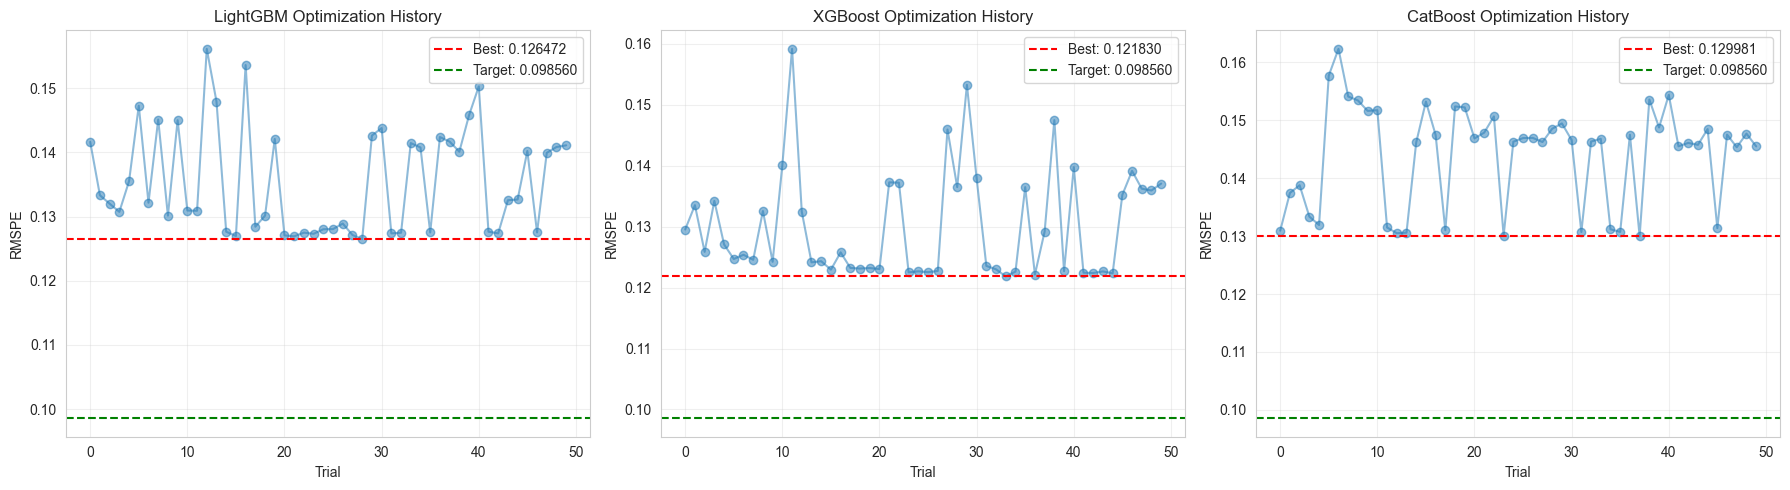

In [13]:
# Optimization history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# LightGBM
ax = axes[0]
trials_lgb = study_lgb.trials
ax.plot([t.number for t in trials_lgb], [t.value for t in trials_lgb], 'o-', alpha=0.5)
ax.axhline(y=study_lgb.best_value, color='r', linestyle='--', label=f'Best: {study_lgb.best_value:.6f}')
ax.axhline(y=target, color='g', linestyle='--', label=f'Target: {target:.6f}')
ax.set_xlabel('Trial')
ax.set_ylabel('RMSPE')
ax.set_title('LightGBM Optimization History')
ax.legend()
ax.grid(True, alpha=0.3)

# XGBoost
ax = axes[1]
trials_xgb = study_xgb.trials
ax.plot([t.number for t in trials_xgb], [t.value for t in trials_xgb], 'o-', alpha=0.5)
ax.axhline(y=study_xgb.best_value, color='r', linestyle='--', label=f'Best: {study_xgb.best_value:.6f}')
ax.axhline(y=target, color='g', linestyle='--', label=f'Target: {target:.6f}')
ax.set_xlabel('Trial')
ax.set_ylabel('RMSPE')
ax.set_title('XGBoost Optimization History')
ax.legend()
ax.grid(True, alpha=0.3)

# CatBoost
ax = axes[2]
trials_cb = study_cb.trials
ax.plot([t.number for t in trials_cb], [t.value for t in trials_cb], 'o-', alpha=0.5)
ax.axhline(y=study_cb.best_value, color='r', linestyle='--', label=f'Best: {study_cb.best_value:.6f}')
ax.axhline(y=target, color='g', linestyle='--', label=f'Target: {target:.6f}')
ax.set_xlabel('Trial')
ax.set_ylabel('RMSPE')
ax.set_title('CatBoost Optimization History')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

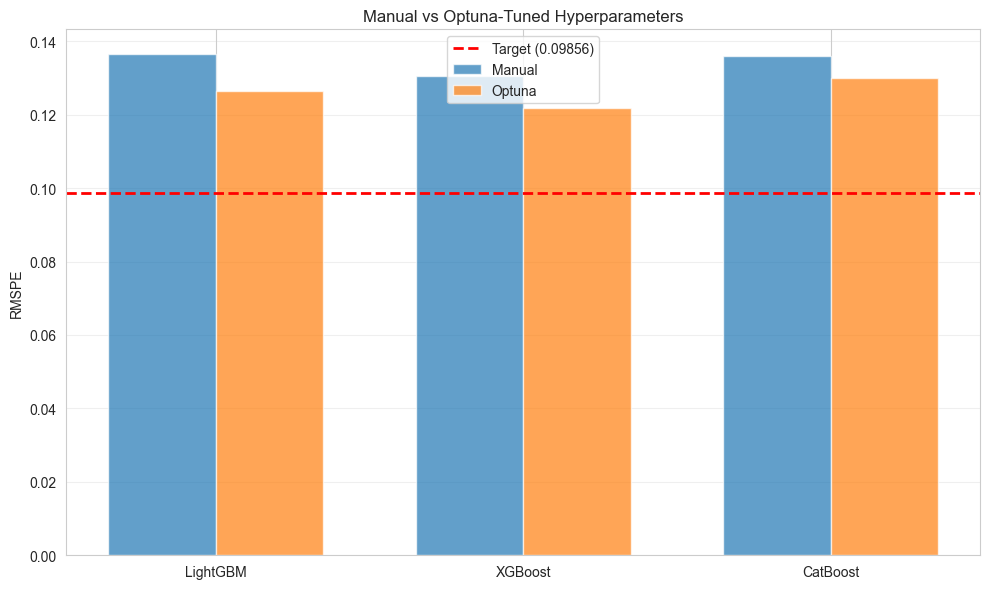

In [14]:
# Comparison bar plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison))
width = 0.35

ax.bar(x - width/2, comparison['Manual RMSPE'], width, label='Manual', alpha=0.7)
ax.bar(x + width/2, comparison['Optuna RMSPE'], width, label='Optuna', alpha=0.7)

ax.axhline(y=target, color='red', linestyle='--', label='Target (0.09856)', linewidth=2)
ax.set_ylabel('RMSPE')
ax.set_title('Manual vs Optuna-Tuned Hyperparameters')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Model'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Summary

In [15]:
print("\n" + "="*70)
print("Hyperparameter Tuning Complete!")
print("="*70)

print(f"\n1. Hyperparameter Optimization:")
print(f"   Optimized {len(comparison)} models with {N_TRIALS} trials each")
print(f"\n   Individual Model Results:")
for idx, row in comparison.iterrows():
    print(f"     {row['Model']}:")
    print(f"       Manual:  {row['Manual RMSPE']:.6f}")
    print(f"       Optuna:  {row['Optuna RMSPE']:.6f}")
    print(f"       Improvement: {row['Improvement (%)']:.2f}%")

print(f"\n2. Best Overall:")
best_model = comparison.loc[comparison['Optuna RMSPE'].idxmin(), 'Model']
best_score = comparison['Optuna RMSPE'].min()
print(f"   Model: {best_model}")
print(f"   RMSPE: {best_score:.6f}")
print(f"   Gap to target (0.09856): {gap:.6f} ({gap_pct:+.2f}%)")

print(f"\n3. MLflow Tracking:")
print(f"   All trials tracked as nested runs in MLflow")
print(f"   View results: bash scripts/start_mlflow.sh")
print(f"   Then open: http://127.0.0.1:5000")

print("="*70)


Hyperparameter Tuning Complete!

1. Hyperparameter Optimization:
   Optimized 3 models with 50 trials each

   Individual Model Results:
     LightGBM:
       Manual:  0.136400
       Optuna:  0.126472
       Improvement: 7.28%
     XGBoost:
       Manual:  0.130598
       Optuna:  0.121830
       Improvement: 6.71%
     CatBoost:
       Manual:  0.136075
       Optuna:  0.129981
       Improvement: 4.48%

2. Best Overall:
   Model: XGBoost
   RMSPE: 0.121830
   Gap to target (0.09856): 0.023270 (+23.61%)

3. MLflow Tracking:
   All trials tracked as nested runs in MLflow
   View results: bash scripts/start_mlflow.sh
   Then open: http://127.0.0.1:5000
